In [11]:
!pip install tensorflow numpy seaborn matplotlib

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_dir = '/usr1/home/s125mdg24_07/Cat vs Dog/datasets/datasets/train'
val_dir = '/usr1/home/s125mdg24_07/Cat vs Dog/datasets/datasets/val'

img_size = (224, 224)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=['cat', 'dog']
)

val_dataset = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  
    classes=['cat', 'dog'] 
)

Found 12267 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [7]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 148s 370ms/step - accuracy: 0.9790 - loss: 0.0562 - val_accuracy: 0.9903 - val_loss: 0.0224
Epoch 2/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 140s 364ms/step - accuracy: 0.9881 - loss: 0.0338 - val_accuracy: 0.9910 - val_loss: 0.0251
Epoch 3/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 140s 364ms/step - accuracy: 0.9896 - loss: 0.0285 - val_accuracy: 0.9910 - val_loss: 0.0217
Epoch 4/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 139s 363ms/step - accuracy: 0.9913 - loss: 0.0273 - val_accuracy: 0.9913 - val_loss: 0.0241
Epoch 5/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 140s 363ms/step - accuracy: 0.9902 - loss: 0.0265 - val_accuracy: 0.9927 - val_loss: 0.0203


In [17]:
pred_probs = model.predict(val_dataset, steps=len(val_dataset))
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_dataset.classes
class_labels = list(val_dataset.class_indices.keys())

accuracy = np.mean(pred_classes == true_classes)
print(f"Validation Accuracy (re-eval): {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step
Validation Accuracy (re-eval): 99.27%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      0.99      0.99      2000
         dog       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



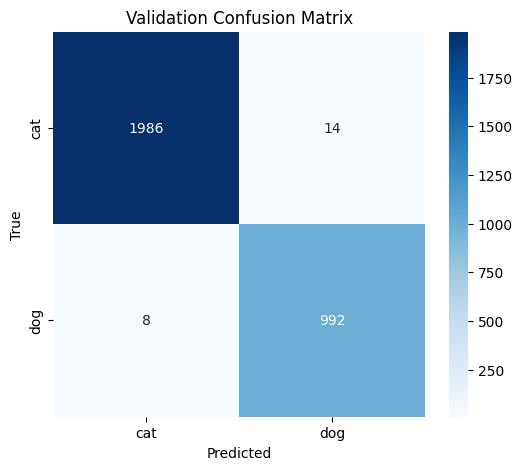

In [18]:
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

Number of misclassified image: 22


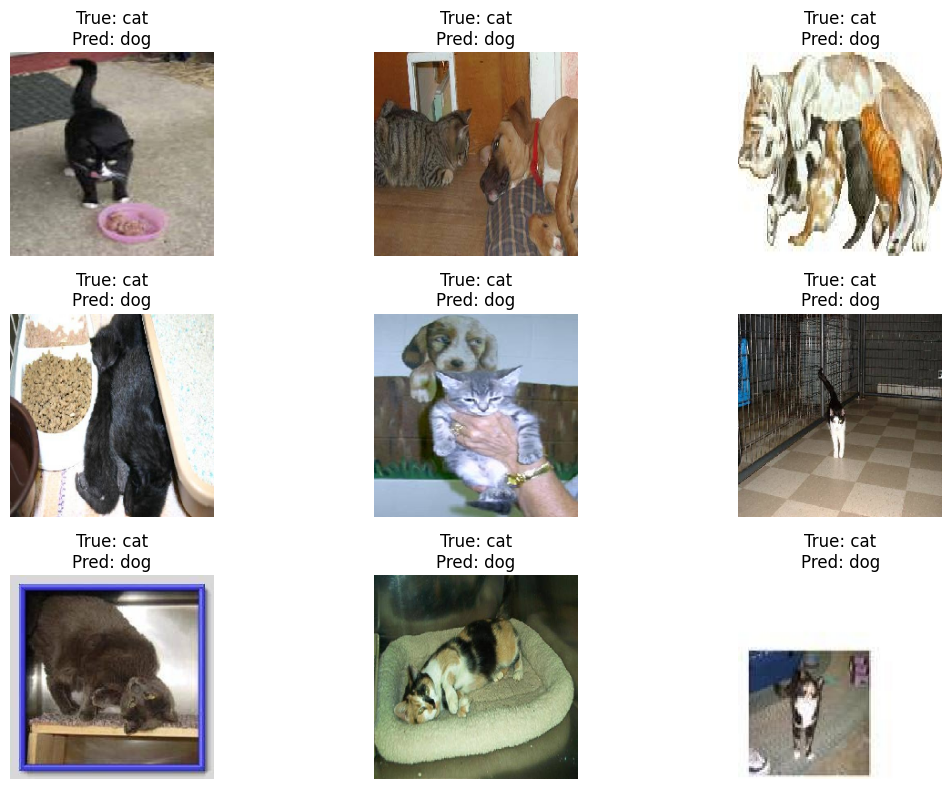

In [20]:
errors = np.where(pred_classes != true_classes)[0]
print(f"Number of misclassified image: {len(errors)}")

if len(errors) > 0:
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(errors[:9]):
        img_path = val_dataset.filepaths[idx]
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[pred_classes[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [26]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

def load_cifar10(data_dir):
    # Training data
    x_train_list = []
    y_train_list = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        x_train_list.append(batch[b'data'])
        y_train_list.append(batch[b'labels'])
    x_train = np.concatenate(x_train_list)
    y_train = np.concatenate(y_train_list)

    # Test data
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    x_test = test_batch[b'data']
    y_test = np.array(test_batch[b'labels'])

    # Reshape images: (num_samples, 3, 32, 32) → (num_samples, 32, 32, 3)
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return x_train, y_train, x_test, y_test

data_dir = '/usr1/home/s125mdg24_07/Cat vs Dog/cifar-10-python/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10(data_dir)
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


In [31]:
# One-hot encode labels
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Resize to EfficientNet input size
IMG_SIZE = 224

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Generator
batch_size = 32
train_generator = train_datagen.flow(
    x=tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)),
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)),
    y=y_test_cat,
    batch_size=batch_size,
    shuffle=False
)

In [32]:
# Base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze initially

# Head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history_head = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 516s 330ms/step - accuracy: 0.8647 - loss: 0.3925 - val_accuracy: 0.9019 - val_loss: 0.2885
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 516s 330ms/step - accuracy: 0.8702 - loss: 0.3746 - val_accuracy: 0.9068 - val_loss: 0.2817
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 517s 330ms/step - accuracy: 0.8768 - loss: 0.3595 - val_accuracy: 0.9097 - val_loss: 0.2668
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 517s 330ms/step - accuracy: 0.8797 - loss: 0.3460 - val_accuracy: 0.9058 - val_loss: 0.2746
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 515s 329ms/step - accuracy: 0.8831 - loss: 0.3364 - val_accuracy: 0.9107 - val_loss: 0.2676
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 516s 330ms/step - accuracy: 0.8859 - loss: 0.3328 - val_accuracy: 0.9115 - val_loss: 0.2661
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 516s 330ms/step - accuracy: 0.8887 - loss: 0.3189 - val_accuracy: 0.9137 - val_loss: 0.2641
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 516s 330ms/step - ac

In [ ]:
# Test accuracy
pred_probs = model.predict(val_generator, steps=len(val_generator))
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test_cat, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Test Accuracy:", accuracy_score(true_classes, pred_classes))
print(classification_report(true_classes, pred_classes))

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
